# Model 1 - Horizontal stratigraphic

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [2]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")


In [4]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [5]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))
#geo_data.formations

In [6]:
#geo_data.set_colors(colormodel)

In [7]:
#%matplotlib inline
#gp.plotting.plot_data(geo_data, direction='y')

In [8]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [9]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


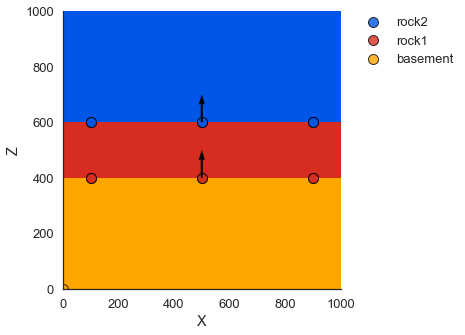

In [10]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model1_pure', edgecolor='black')

In [11]:
import gempy.utils.Kriging_Jan as krige

In [12]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  500  10  500        20
1  500  10  500        20


In [13]:
np.random.seed(13124)

In [14]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', an_factor=1, var_par=(200,50,1))

initializing: 0.009545087814331055
distance precalculation: 0.383056640625
4000
submatrix extraction: 0.013262271881103516
distance Matrices: 0.4203920364379883
kriging calculation: 0.6629750728607178
Negative Variances: 0
Out of: 4001


In [15]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

In [16]:
colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

In [17]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

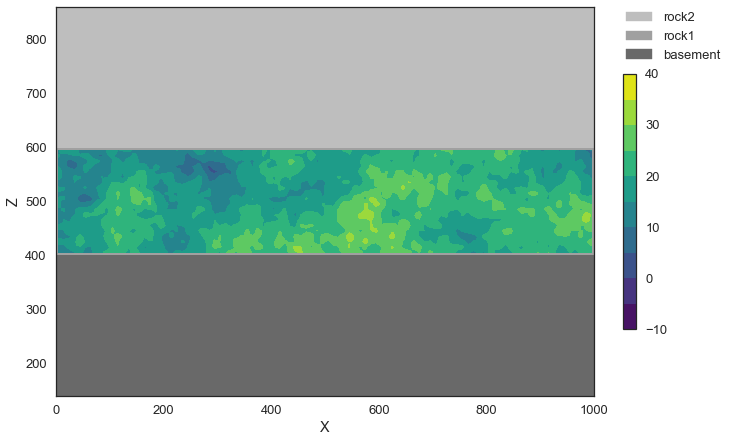

In [18]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_SGS_truth', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [19]:
# Sampling
def random_sampling(data):
    #print(len(data))
    rand_pos = np.random.randint(0,len(data),50)
    #print(rand_pos)
    #print(rand_pos.shape)
    samples = data[rand_pos]
    return samples

In [20]:
samples = random_sampling(combined)

In [21]:
d = {'X': samples[:,0], 'Y': samples[:,1], 'Z': samples[:,2], 'Property': samples[:,3]}
data_field_sampled = pd.DataFrame(data=d)
#print(data_field)

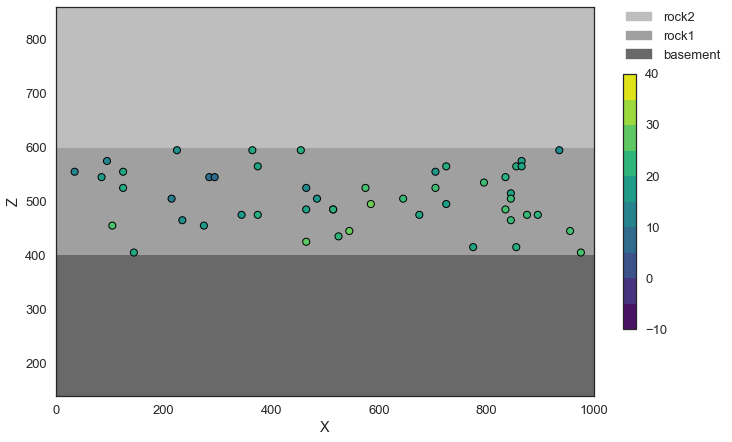

In [22]:
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.scatter(x=samples[:,0], y=samples[:,2], c=samples[:,3], s=50, cmap='viridis', linewidths=1, edgecolors='black', norm=norm)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_sampling', edgecolor='black', bbox_inches='tight')

In [23]:
np.random.seed(1312434)

In [24]:
simulation = krige.Kriging(data_field_sampled, lith_block, geo_data, formation_number=2, kriging_type='SK', distance_type='euclidian', var_par=(50,50,1))

initializing: 0.022498130798339844
distance precalculation: 0.29632568359375
4000
submatrix extraction: 0.03316473960876465
distance Matrices: 0.5132644176483154
kriging calculation: 0.6124768257141113
Negative Variances: 0
Out of: 4000


In [25]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

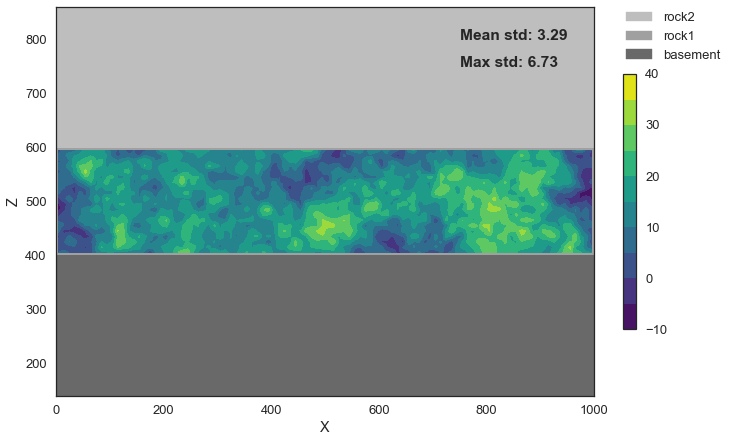

In [26]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)
plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_SK_50_50_1_mean=0', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [27]:
np.random.seed(1312434)

In [28]:
simulation = krige.Kriging(data_field_sampled, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', var_par=(200,50,1))

initializing: 0.014268875122070312
distance precalculation: 0.5702610015869141
4000
submatrix extraction: 0.00907588005065918
distance Matrices: 0.4965095520019531
kriging calculation: 0.9859473705291748
Negative Variances: 0
Out of: 4000


In [29]:
#print(simulation.std[:len(simulation.std)-49])

In [30]:
import scipy.optimize as opt

(1, 3.5)

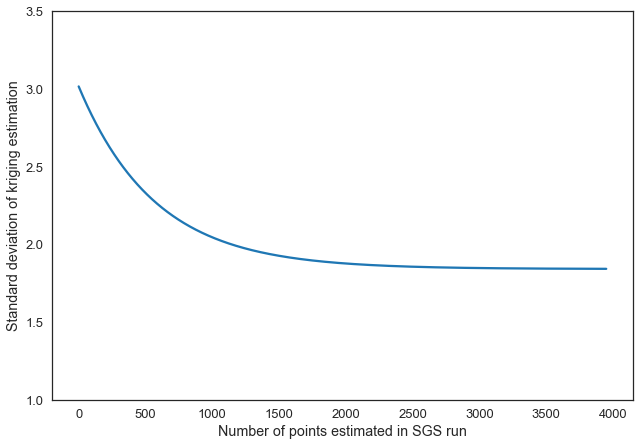

In [31]:

#plt.scatter(np.arange(0,len(simulation.std)-49,1), simulation.std[:len(simulation.std)-49], zorder=-1)

def func(x, a, b, c):
     return a * np.exp(-b * x) + c
    
optimizedParameters, pcov = opt.curve_fit(func, np.arange(0,len(simulation.std)-49,1), simulation.std[:len(simulation.std)-49])
plt.plot(np.arange(0,len(simulation.std)-49,1), func(np.arange(0,len(simulation.std)-49,1), *optimizedParameters), label="fit")

plt.ylabel('Standard deviation of kriging estimation')
plt.xlabel('Number of points estimated in SGS run')
plt.ylim((1,3.5))

In [32]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

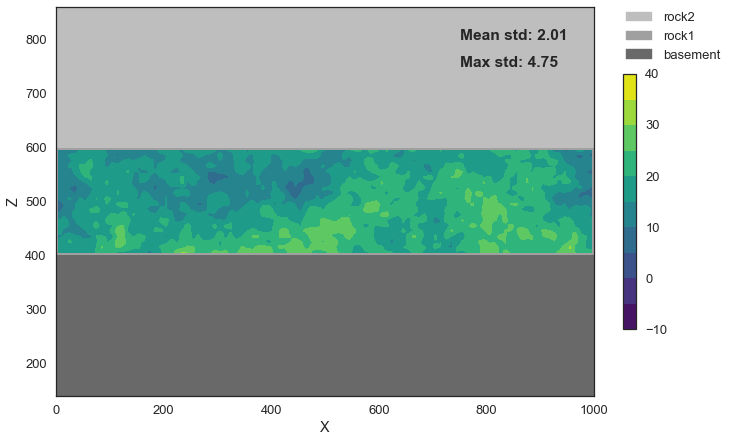

In [33]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(0-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_OK_200_50_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

# UK preparation

In [55]:
data_field_sampled_UK = data_field_sampled
print(data_field_sampled)
x = data_field_sampled['X'].values
prop = data_field_sampled['Property'].values

        X     Y      Z   Property
0   875.0   0.1  475.0  31.288151
1   285.0   0.1  545.0   3.978246
2   775.0  19.9  415.0  24.876601
3   845.0   0.1  465.0  30.729518
4   575.0  19.9  525.0  26.691524
5   865.0   0.1  575.0  25.681692
6   485.0  19.9  505.0  15.739791
7   835.0   0.1  545.0  28.657101
8    95.0   0.1  575.0   4.623209
9   705.0  19.9  555.0  21.138976
10  935.0   0.1  595.0  22.725083
11  455.0   0.1  595.0  20.025793
12  855.0  19.9  565.0  27.693633
13  295.0   0.1  545.0   3.224393
14  125.0  19.9  555.0  12.229102
15  235.0   0.1  465.0   9.570860
16  125.0  19.9  525.0  13.249530
17  855.0   0.1  415.0  28.196903
18  215.0  19.9  505.0   5.307792
19  465.0  19.9  525.0  12.545012
20   35.0  19.9  555.0   3.566718
21  365.0  19.9  595.0  17.055426
22  705.0   0.1  525.0  28.795091
23   85.0  19.9  545.0   9.226617
24  675.0  19.9  475.0  22.635822
25  725.0  19.9  495.0  22.550356
26  835.0   0.1  485.0  31.813705
27  515.0  19.9  485.0  22.747382
28  105.0  19.

In [56]:
def linear_trend(x):
    prop_res = np.zeros(len(x))
    prop_res[:]= 0.01*(x[:])+15
    return prop_res

def linear_trend_data(x, prop):
    prop_res = np.zeros(len(x))
    prop_res[:]= prop[:]+0.01*(x[:])-5
    return prop_res

In [57]:
new_prop=linear_trend_data(x, prop)
print(new_prop)
data_field_sampled_UK['Property']=new_prop
#print(data_field_sampled_UK)

[35.03815057  1.82824607 27.62660086 34.17951792 27.4415244  29.33169171
 15.58979076 32.00710064  0.57320851 23.18897612 27.07508277 19.57579349
 31.24363301  1.17439263  8.47910213  6.9208605   9.49953015 31.74690327
  2.45779208 12.19501175 -1.08328212 15.70542552 30.84509086  5.07661732
 24.38582185 24.80035562 35.16370534 22.89738166 13.68341251 18.00867769
 39.7684237  10.03233926 29.65198539  9.80226858 33.30829975 23.2877069
 31.44310193 30.25736659 22.38678651 29.08123822 26.27888316 38.66499036
 15.36613264 28.09200297 34.2503397  12.40752111 17.27274544 28.10019861
 34.0157001   6.79466983]


In [58]:
prop_trend = linear_trend(x)
print(prop_trend)

[23.75 17.85 22.75 23.45 20.75 23.65 19.85 23.35 15.95 22.05 24.35 19.55
 23.55 17.95 16.25 17.35 16.25 23.55 17.15 19.65 15.35 18.65 22.05 15.85
 21.75 22.25 23.35 20.15 16.05 18.75 24.75 17.75 20.45 16.45 22.95 20.25
 20.85 23.65 20.15 23.45 19.65 24.55 18.75 21.45 23.95 18.45 19.65 22.25
 23.45 17.25]


# UK

In [59]:
residuals = np.abs(new_prop - prop_trend)
print(residuals)

[11.28815057 16.02175393  4.87660086 10.72951792  6.6915244   5.68169171
  4.26020924  8.65710064 15.37679149  1.13897612  2.72508277  0.02579349
  7.69363301 16.77560737  7.77089787 10.4291395   6.75046985  8.19690327
 14.69220792  7.45498825 16.43328212  2.94457448  8.79509086 10.77338268
  2.63582185  2.55035562 11.81370534  2.74738166  2.36658749  0.74132231
 15.0184237   7.71766074  9.20198539  6.64773142 10.35829975  3.0377069
 10.59310193  6.60736659  2.23678651  5.63123822  6.62888316 14.11499036
  3.38386736  6.64200297 10.3003397   6.04247889  2.37725456  5.85019861
 10.5657001  10.45533017]


In [39]:
def exponential_variogram_model(self, d):
    psill = self.sill - self.nugget
    gamma = psill * (1. - np.exp(-(np.absolute(d) / (self.range_)))) + self.nugget
    return gamma

In [40]:
#print(data_field_sampled_UK[['X','Z']].values)

In [60]:
from scipy import spatial

In [61]:
pos = 0
h = np.empty((len(residuals), len(residuals)))
gamma = np.empty((len(residuals), len(residuals)))

data_m = data_field_sampled_UK[['X','Y','Z']].values
#print(data_m)
data_v = residuals


for pos in range (len(residuals)):
    for i in range (len(residuals)):
        gamma[pos, i] = ((data_v[i]-data_v[pos])**2)/2
        h[pos, i] = spatial.distance.euclidean(data_m[i], data_m[pos])

In [62]:
bins = 50
maxim = 1000
bin_size = maxim/bins
a = 0

h_bins = np.empty(bins)
ave_vals = np.empty(bins)

for j in range (bins):
    bi = np.where((h > a)*(h < (a+bin_size)))
    ave_vals[j] = np.average(gamma[bi])
    h_bins[j] = (a+a+bin_size)/2
    a += bin_size

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


No handles with labels found to put in legend.


(0, 54.05475376111165)

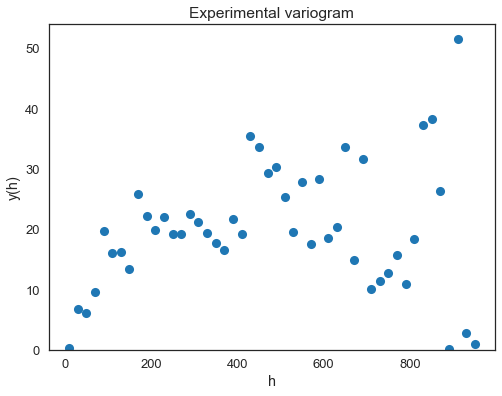

In [63]:
#plot figure
plt.figure(figsize=(8,6))
plt.plot(h_bins, ave_vals,'o')
plt.xlabel("h")
plt.ylabel("y(h)")
plt.title('Experimental variogram')
#plt.plot(h, experimental_variogram_model(h, gaussian_range, gaussian_sill),'-',label='Gaussian')
plt.legend(loc ='best')
plt.ylim(0)

In [45]:
np.random.seed(1312434)

In [46]:
simulation = krige.Kriging(data_field_sampled_UK, lith_block, geo_data, formation_number=2, kriging_type='UK', distance_type='euclidian', var_par=(100,10,1))

initializing: 0.010069131851196289
distance precalculation: 0.21331167221069336
4000
submatrix extraction: 3.218650817871094e-05
distance Matrices: 0.36350154876708984
kriging calculation: 0.7795462608337402
Negative Variances: 0
Out of: 4000


In [47]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

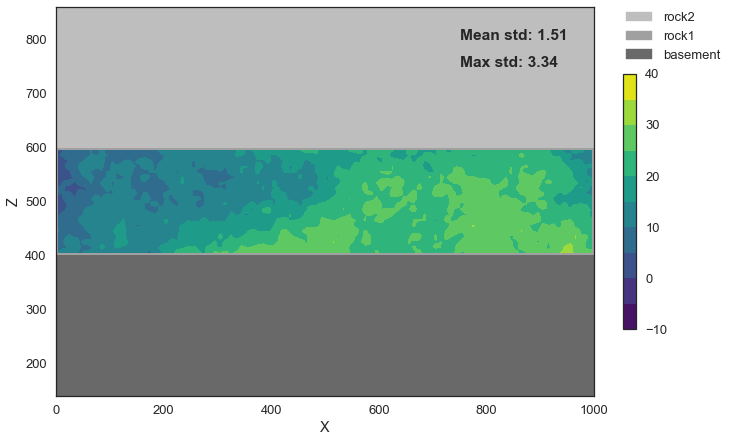

In [48]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)
#a = plt.contourf(X, Y, Z, cmap='viridis')

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_ukdata_UK_100_10_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [49]:
np.random.seed(1312434)

In [50]:
simulation = krige.Kriging(data_field_sampled_UK, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', var_par=(200,50,1))

initializing: 0.02070903778076172
distance precalculation: 0.2904093265533447
4000
submatrix extraction: 0.010105371475219727
distance Matrices: 0.2994663715362549
kriging calculation: 0.4837453365325928
Negative Variances: 0
Out of: 4000


In [51]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

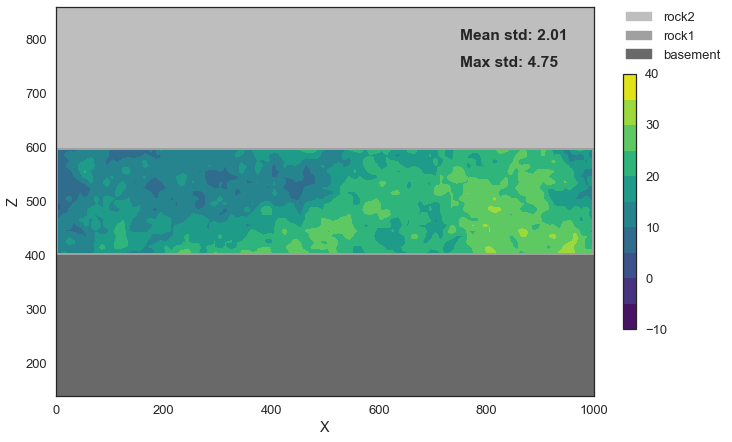

In [52]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=-10, vmax=40)
v = np.linspace(-10, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.text(750,800,'Mean std: %s'%np.round(np.mean(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')
plt.text(750,750,'Max std: %s'%np.round(np.max(simulation.std[:len(simulation.std)-49]),2), fontweight='bold')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Example_SGS_Ukdata_OK_200_50_1', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()